In [1]:
import sys
sys.path.append('../')
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter, PercentFormatter
import matplotlib as mpl
import numpy as np

from utils import db

conn = db.connect()
pd.set_option('display.max_rows', 100)
# pd.set_option("display.max_rows", None, "display.max_columns", None)

# pd.read_sql("""SELECT * FROM stakes""", conn)

## Key analysis categories:
- Top 25 accounts: days staked & amount over time
- Demographics of long duration stakers vs. short duration
- Demographics of committed stakers vs. early withdrawers
- Demographics of high frequency stakers
- When did stakers unstake?
- long time staked, large quantity staked, high frequency new stakes, low early unstaking
- Uniswap liquidity stability

In [2]:
pd.read_sql("""SELECT 
   table_name, 
   column_name, 
   data_type 
FROM 
   information_schema.columns
WHERE 
   table_name = 'stakes';""",conn)

,table_name,column_name,data_type
0,stakes,fromaddress,text
1,stakes,staketransactionhash,text
2,stakes,stakeid,text
3,stakes,stakedatetime,date
4,stakes,amountin,numeric
5,stakes,mintedamount,numeric
6,stakes,expiredatetime,date
7,stakes,totalstakeddays,numeric
8,stakes,dapprewardamount,numeric
9,stakes,dapppooladdress,text


In [4]:
pd.read_sql("""SELECT *
FROM stakes
LIMIT 1;""",conn)

,fromaddress,staketransactionhash,stakeid,stakedatetime,amountin,mintedamount,expiredatetime,totalstakeddays,dapprewardamount,dapppooladdress,unstaketransactionhash,unstakedatetime,unstakeearlyburnedamount,matchedamount,flashversion,v2migrationtransactionhash
0,0xee0be24481e9079ba33055b1af41c28660377d76,0x601cb3df68d0d0b6ac7af75a01a1d9ff510f4244d12f...,0xb5797b2fe6d0db876f743d679d9beb5b8efe0e8ee92c...,2021-08-23,49664.390056,24741.396256,2023-07-06,682.0,0.110263,0xc9fc5a6007c9801ebae1813d4d03208c4e85be44,None,None,None,0.0,2,None


In [5]:
pd.read_sql("""SELECT 
   table_name, 
   column_name, 
   data_type 
FROM 
   information_schema.columns
WHERE 
   table_name = 'uniswap';""",conn)

,table_name,column_name,data_type
0,uniswap,date,date
1,uniswap,liquidity,numeric
2,uniswap,value,numeric
3,uniswap,price,numeric


In [6]:
pd.read_sql("""SELECT fromaddress, COUNT(fromaddress)
FROM stakes
GROUP BY fromaddress
ORDER BY fromaddress DESC;""",conn)

,fromaddress,count
0,0xff6992fda98a9452e2eb0487e17533f428be6bdc,6
1,0xff53e3a27b7252148e0f1daf4a00261eee59177f,1
2,0xff4b28d2403ae65311cbdc0f0fac33f2d504648a,1
3,0xff2469082cc5bf7e626fbfa9c25f467411d84cc2,1
4,0xfefe61d43844bd8b034a11f33c88b5c9ed1caae1,4
...,...,...
810,0x01b2f6622b0815194b805df29b053c13a75f7363,1
811,0x00e56d0929070567b7d885ba90d79427f2882943,2
812,0x00dd07f525b82759313e9d0148b1344ca234dbc7,1
813,0x00b8cf5347b1d716af821df508f0c6a9037a367a,6


In [7]:
pd.options.display.float_format = '{:,.2f}'.format
pd.read_sql("""SELECT fromaddress, SUM(AmountIn) as TotalStaked
FROM stakes
GROUP BY fromaddress
ORDER BY TotalStaked DESC;""",conn)

,fromaddress,totalstaked
0,0x7dc0a282fcc494ef0ea59cba06f8709c04c1aee5,"5,819,928.53"
1,0x7f36ed45831bc34e38fd27145b6f983856fcb0dd,"2,096,016.93"
2,0x254242457f3f61d9050e451a61a107ea92d5e2b1,"1,392,723.89"
3,0xd0f50c0431b76fa58aeefdd68617acb4e0628051,"1,045,374.27"
4,0x7407ca3def8bda3239fc7069863c54f2cc2c80bd,"1,037,473.00"
...,...,...
810,0x3e9cc912b72c0b6ecbdc0e18bb572d2f58d43fe6,22.00
811,0x022db6a078679e8e8bafa64d305f656de50109fd,21.44
812,0x74ae284dd6044db63dc268f52131571a3b80ad33,16.61
813,0x8a1d03f13f7de4ae4ae9986c804c959b9ed29bfb,10.00


In [221]:
pd.read_sql("""SELECT fromaddress, AmountIn as TotalStaked, stakedatetime, unstakedatetime
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND ((unstakedatetime - stakedatetime >= 90 OR unstakedatetime=NULL) AND totalstakeddays >= 90)
ORDER BY TotalStaked DESC
LIMIT 10;""",conn)

,fromaddress,totalstaked,stakedatetime,unstakedatetime
0,0x54e7452428ba68a3445356b44a6e1c11b73fe4b2,"401,184.00",2021-05-04,2021-08-11
1,0x09ea768029069eeb979015a64f261e7789e5e450,"167,000.00",2021-05-09,2021-08-12
2,0xe2e8fee9ac2af4352a0e424650b77da25c36bf80,"150,000.00",2021-05-09,2021-08-08
3,0xd0f50c0431b76fa58aeefdd68617acb4e0628051,"100,000.00",2021-04-13,2021-08-04
4,0xc848b603a557bef9dc9c3e8d9737691586b9e56b,"92,385.90",2021-03-13,2021-08-21
5,0x02d6ff4516a81b4f425a7063df670b33f4c62918,"84,331.26",2021-03-20,2021-07-22
6,0x95551cf63f5794287ab2ab4ffdb3b07b3df31702,"70,275.00",2021-04-04,2021-07-19
7,0xd0f50c0431b76fa58aeefdd68617acb4e0628051,"48,506.45",2021-04-07,2021-08-04
8,0x7075191e9054c8b7460fc3e761f9d0a499a688d3,"41,898.56",2021-04-18,2021-07-18
9,0xd406c013b7419158ca68617ecf7d3e3f40800c13,"40,000.00",2021-04-02,2021-07-31


In [9]:
pd.read_sql("""SELECT fromaddress, amountin, unstakedatetime
FROM stakes
WHERE fromaddress='0xf1a7b8b3d6a69c30883b2a3fb023593d9bb4c81e' AND stakedatetime < '2021-07-01'::date
ORDER BY amountin DESC;""",conn)

,fromaddress,amountin,unstakedatetime
0,0xf1a7b8b3d6a69c30883b2a3fb023593d9bb4c81e,"110,100.00",None
1,0xf1a7b8b3d6a69c30883b2a3fb023593d9bb4c81e,"110,100.00",2021-06-12
2,0xf1a7b8b3d6a69c30883b2a3fb023593d9bb4c81e,"110,100.00",2021-05-12
3,0xf1a7b8b3d6a69c30883b2a3fb023593d9bb4c81e,"110,000.00",None


In [10]:
# pd.read_sql("""SELECT fromaddress, COUNT(stakedatetime) AS "Completed Stakes"
# FROM stakes
# WHERE (unstakedatetime IS NOT null AND unstakeearlyburnedamount IS null) AND fromaddress LIKE '0x254242457f3f61d9050e451a61a107ea92d5e2b1'
# GROUP BY fromaddress;""",conn)

pd.read_sql("""SELECT * FROM
(
    SELECT fromaddress, SUM(amountin) as "Total Staked", MIN(stakedatetime) AS "Earliest Stake", AVG(coalesce(unstakedatetime, CURRENT_DATE) - stakedatetime) AS "Avg Actual Staked Days", MAX(flashversion) AS "Latest Version" 
    FROM stakes
    WHERE (stakedatetime < '2021-07-01'::date AND ((unstakedatetime - stakedatetime >= 90 OR unstakedatetime IS null) AND totalstakeddays >= 90)) AND fromaddress LIKE '0x254242457f3f61d9050e451a61a107ea92d5e2b1'
    GROUP BY fromaddress
    HAVING SUM(amountin) > 100000
) min_stakes
JOIN
(
    SELECT fromaddress, COUNT(stakedatetime) AS "Completed Stakes"
    FROM stakes
    WHERE (unstakedatetime IS NOT null AND unstakeearlyburnedamount IS null) AND fromaddress LIKE '0x254242457f3f61d9050e451a61a107ea92d5e2b1'
    GROUP BY fromaddress
) completed_stakes
ON completed_stakes.fromaddress=min_stakes.fromaddress
ORDER BY "Total Staked" DESC;""",conn)

,fromaddress,Total Staked,Earliest Stake,Avg Actual Staked Days,Latest Version,fromaddress,Completed Stakes
0,0x254242457f3f61d9050e451a61a107ea92d5e2b1,"582,789.90",2021-01-02,221.71,2,0x254242457f3f61d9050e451a61a107ea92d5e2b1,1


In [220]:
pd.options.display.float_format = '{:,.2f}'.format
# stakes.fromaddress AS "Account", SUM(stakes.amountin) as "Total Staked", MIN(stakes.stakedatetime) AS "Earliest Stake", AVG(coalesce(stakes.unstakedatetime, CURRENT_DATE) - stakes.stakedatetime) AS "Avg Actual Staked Days", COUNT(completed_stakes.completedcount) AS "Completed Stakes", COUNT(coalesce(open_stakes.opencount,0)) AS "Open Stakes", MAX(stakes.flashversion) AS "Latest Version"
# WHERE stakedatetime < '2021-07-01'::date AND ((unstakedatetime - stakedatetime >= 90 OR unstakedatetime IS null) AND totalstakeddays >= 90)
stks = pd.read_sql("""SELECT stakes.fromaddress AS "Account", stakes.totalstaked AS "Total Quantity Staked", stakes.earlieststake AS "Earliest Stake", stakes.avgactualstakeddays AS "Avg Actual Staked Days", stakes.numberofstakes AS "Number of Stakes", coalesce(completed_stakes.completedcount, 0) AS "Completed Stakes", coalesce(open_stakes.opencount, 0) AS "Open Stakes", stakes.latestversion AS "Latest Version"
FROM
(
    SELECT fromaddress, SUM(amountin) AS totalstaked, MIN(stakedatetime) AS earlieststake, AVG(coalesce(unstakedatetime, CURRENT_DATE) - stakedatetime) AS avgactualstakeddays, COUNT(stakedatetime) AS numberofstakes, MAX(flashversion) AS latestversion
    FROM stakes
    WHERE stakedatetime < '2021-07-01'::date AND ((unstakedatetime - stakedatetime >= 90 OR unstakedatetime IS null) AND totalstakeddays >= 90)
    GROUP BY fromaddress
    HAVING SUM(stakes.amountin) > 100000
) stakes
LEFT JOIN
(
    SELECT fromaddress, COUNT(stakedatetime) AS completedcount
    FROM stakes
    WHERE stakedatetime < '2021-07-01'::date AND (totalstakeddays >= 90 AND (unstakedatetime IS NOT null AND unstakeearlyburnedamount IS null))
    GROUP BY fromaddress
) completed_stakes
ON completed_stakes.fromaddress=stakes.fromaddress
LEFT JOIN
(
    SELECT fromaddress, COUNT(stakedatetime) AS opencount
    FROM stakes
    WHERE stakedatetime < '2021-07-01'::date AND (unstakedatetime IS null AND totalstakeddays >= 90)
    GROUP BY fromaddress
) AS open_stakes
ON open_stakes.fromaddress=stakes.fromaddress
ORDER BY "Total Quantity Staked" DESC
LIMIT 10;""",conn)
# stks.to_csv("top_stakes_summary.csv")
display(stks)

,Account,Total Quantity Staked,Earliest Stake,Avg Actual Staked Days,Number of Stakes,Completed Stakes,Open Stakes,Latest Version
0,0xbe4c3b530b92157811ef87f53123753a9cf0012c,"686,303.21",2021-01-16,234.00,3,0,3,1
1,0x254242457f3f61d9050e451a61a107ea92d5e2b1,"582,789.90",2021-01-02,223.71,24,0,24,2
2,0x77342cdc64678df4261b273ad29da9e3c000decb,"450,000.00",2021-02-16,180.00,2,0,2,2
3,0xd0f50c0431b76fa58aeefdd68617acb4e0628051,"443,638.89",2021-01-01,194.50,6,0,4,2
4,0x5da9ac2b36fe8415df9ac15e3fbee99de5dc000a,"426,876.33",2021-03-16,123.00,9,0,8,2
5,0x4c8475548d821e2e4d7f2e3bd2d83a32fff8131a,"426,778.72",2021-01-06,230.67,3,0,3,1
6,0xfe828ee52f00e2e928fbd6060ed9a0322fd886e7,"404,060.00",2021-02-12,198.75,4,0,4,2
7,0x54e7452428ba68a3445356b44a6e1c11b73fe4b2,"401,184.00",2021-05-04,99.00,1,1,0,2
8,0x7407ca3def8bda3239fc7069863c54f2cc2c80bd,"388,093.75",2021-04-28,116.00,3,0,3,2
9,0xe2e8fee9ac2af4352a0e424650b77da25c36bf80,"225,220.89",2021-02-08,172.83,6,0,5,2


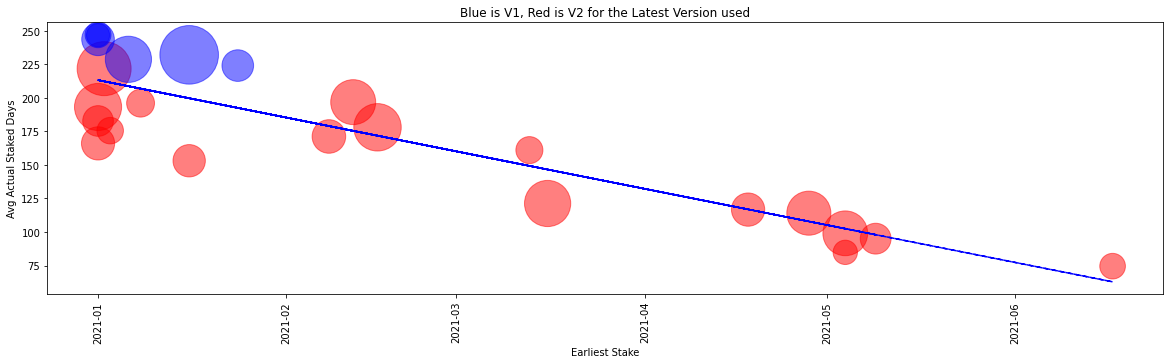

In [12]:
hodlers = pd.read_sql("""SELECT fromaddress AS "Account", SUM(amountin) as "Total Staked", MIN(stakedatetime) AS "Earliest Stake", AVG(coalesce(unstakedatetime, CURRENT_DATE) - stakedatetime) AS "Avg Actual Staked Days", MAX(flashversion) AS "Latest Version" 
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND ((unstakedatetime - stakedatetime >= 90 OR unstakedatetime IS null) AND totalstakeddays >= 90)
GROUP BY fromaddress
HAVING SUM(amountin) > 100000
ORDER BY "Total Staked" DESC;""",conn)

colors = ["Red" if v==2 else "Blue" for v in hodlers["Latest Version"]]
ax = hodlers.plot.scatter(x="Earliest Stake", y="Avg Actual Staked Days", s=hodlers["Total Staked"] / 200, c=colors, rot=90, alpha=0.5, figsize=(20,5));
# ax.set_xticklabels(['{:%m-%d}'.format(d) for d in hodlers['earlieststake']])
# ax.set_xticklabels(['{:%d-:%d}'.format(d.month, d.day) for d in hodlers['earlieststake']])
# ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
# plt.gca().invert_xaxis()
# plt.text('2021-04-01', 100, 'Brackmard minimum')
plt.title("Blue is V1, Red is V2 for the Latest Version used")

# Regression Fitting
x = mdates.date2num(hodlers["Earliest Stake"])
y = hodlers["Avg Actual Staked Days"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
plt.show()

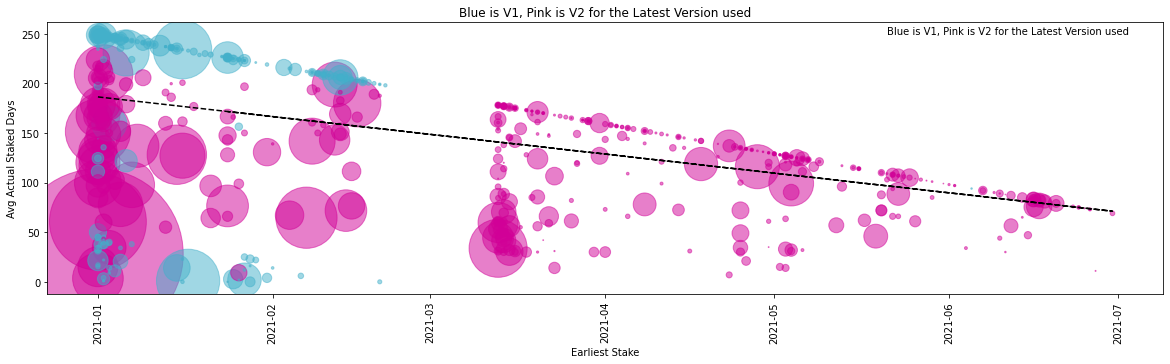

In [216]:
hodlers = pd.read_sql("""SELECT fromaddress AS "Account", SUM(amountin) as "Total Staked", MIN(stakedatetime) AS "Earliest Stake", AVG(coalesce(unstakedatetime, CURRENT_DATE) - stakedatetime) AS "Avg Actual Staked Days", MAX(flashversion) AS "Latest Version" 
FROM stakes
WHERE stakedatetime < '2021-07-01'::date
GROUP BY fromaddress
ORDER BY "Total Staked" DESC;""",conn)

colors = ["#D10097" if v==2 else "#43B0CA" for v in hodlers["Latest Version"]]
ax = hodlers.plot.scatter(x="Earliest Stake", y="Avg Actual Staked Days", s=hodlers["Total Staked"] / 200, c=colors, rot=90, alpha=0.5, figsize=(20,5));
# ax.set_xticklabels(['{:%m-%d}'.format(d) for d in hodlers['earlieststake']])
# ax.set_xticklabels(['{:%d-:%d}'.format(d.month, d.day) for d in hodlers['earlieststake']])
# ax.xaxis.set_major_formatter(DateFormatter('%m-%d'))
# plt.gca().invert_xaxis()
plt.text(datetime.date(2021,5,21), 250, 'Blue is V1, Pink is V2 for the Latest Version used')
plt.title("Blue is V1, Pink is V2 for the Latest Version used")

# Regression Fitting
x = mdates.date2num(hodlers["Earliest Stake"])
y = hodlers["Avg Actual Staked Days"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"k--")
plt.show()

In [219]:
pd.read_sql("""SELECT fromaddress AS "Account", SUM(amountin) as "Total Staked", MIN(stakedatetime) AS "Earliest Stake", AVG(coalesce(unstakedatetime, CURRENT_DATE) - stakedatetime) AS "Avg Actual Staked Days", MAX(flashversion) AS "Latest Version" 
FROM stakes
WHERE stakedatetime < '2021-07-01'::date
GROUP BY fromaddress
ORDER BY "Total Staked" DESC
LIMIT 10;""",conn)

,Account,Total Staked,Earliest Stake,Avg Actual Staked Days,Latest Version
0,0x7dc0a282fcc494ef0ea59cba06f8709c04c1aee5,5.819929e+06,2021-01-01,27.928571,2
1,0x7f36ed45831bc34e38fd27145b6f983856fcb0dd,1.876497e+06,2021-01-01,60.555556,2
2,0xd0f50c0431b76fa58aeefdd68617acb4e0628051,8.481378e+05,2021-01-01,151.400000,2
3,0xa58698b81714ebe8ff5123ecfd45f2241884a1c1,8.000000e+05,2021-01-17,1.000000,1
4,0xff6992fda98a9452e2eb0487e17533f428be6bdc,7.504000e+05,2021-02-07,64.600000,2
5,0x5da9ac2b36fe8415df9ac15e3fbee99de5dc000a,7.055622e+05,2021-01-15,128.090909,2
6,0xbe4c3b530b92157811ef87f53123753a9cf0012c,6.863032e+05,2021-01-16,234.000000,1
7,0x254242457f3f61d9050e451a61a107ea92d5e2b1,6.859013e+05,2021-01-02,209.461538,2
8,0x09ea768029069eeb979015a64f261e7789e5e450,6.745160e+05,2021-03-13,33.800000,2
9,0x7be805c703cb3f2e76af4905d777c84facc67199,5.138075e+05,2021-01-01,3.547945,2


In [13]:
# regression = pd.OLS(y=y, x=x)
# regression.summary

import statsmodels.api as sm
model = sm.OLS(y, x).fit()
predictions = model.predict(x) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Avg Actual Staked Days   R-squared (uncentered):                   0.911
Model:                                OLS   Adj. R-squared (uncentered):              0.907
Method:                     Least Squares   F-statistic:                              235.3
Date:                    Sun, 05 Sep 2021   Prob (F-statistic):                    1.43e-13
Time:                            16:10:03   Log-Likelihood:                         -129.64
No. Observations:                      24   AIC:                                      261.3
Df Residuals:                          23   BIC:                                      262.4
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0092      0.001     15.341      0.000       0.008       0.010
==============================================================================
Omnibus:                        3.057   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.217   Jarque-Bera (JB):                1.528
Skew:                          -0.279   Prob(JB):                        0.466
Kurtosis:                       1.897   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

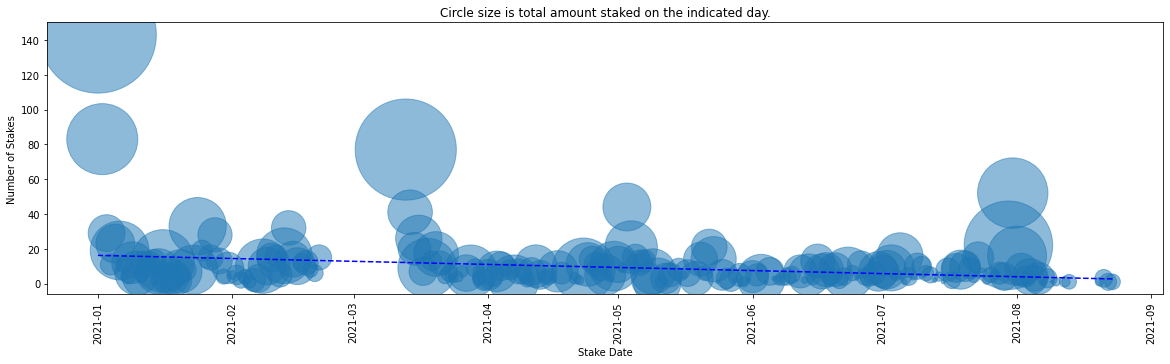

In [14]:
freq = pd.read_sql("""SELECT stakedatetime AS "Stake Date", COUNT(fromaddress) AS "Number of Stakes", SUM(amountin) as "Total Staked"
FROM stakes
GROUP BY stakedatetime
ORDER BY stakedatetime DESC;""",conn)

ax = freq.plot.scatter(x="Stake Date", y="Number of Stakes", s=freq["Total Staked"] / 200, rot=90, alpha=0.5, figsize=(20,5));
plt.title("Circle size is total amount staked on the indicated day.")

# Regression Fitting
x = mdates.date2num(freq["Stake Date"])
y = freq["Number of Stakes"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
plt.show()

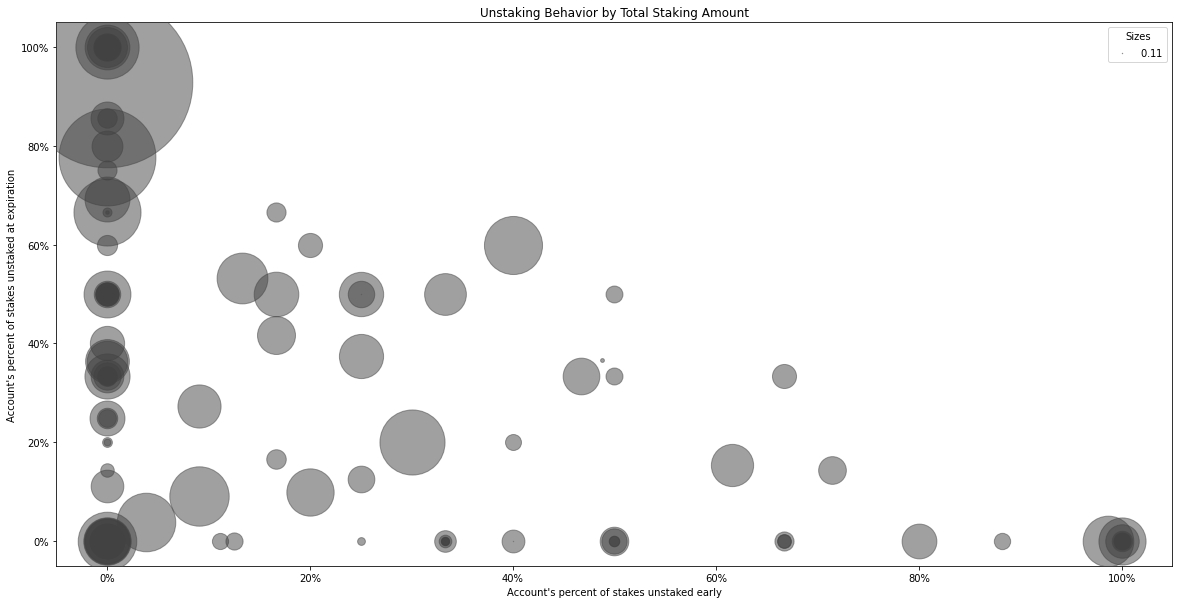

In [146]:
demog = pd.read_sql("""SELECT fromaddress,
    to_timestamp(avg(extract(epoch from stakedatetime)))::date AS avgstakedate,
    to_timestamp(avg(extract(epoch from unstakedatetime)))::date AS avgunstakedate,
    COUNT(stakedatetime) AS stakecount,
    COUNT(unstakedatetime) AS unstakecount,
    COUNT(unstakeearlyburnedamount) as unstakeearlycount,
    SUM(amountin) as staketotal,
    SUM(unstakeearlyburnedamount) as burntotal
FROM stakes
WHERE stakedatetime < '2021-07-15'::date
GROUP BY fromaddress
ORDER BY avgstakedate DESC;""",conn)
# display(best)

fig, ax1 = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)

x1 = demog["avgstakedate"]
y1 = demog["stakecount"]
y2 = demog["unstakecount"]
y3 = demog["unstakeearlycount"]
s1 = demog["staketotal"]
d1 = demog["avgstakedate"]
d2 = demog["avgunstakedate"]
for i in range(0, len(x1)):
#     print("%s, %5.2f" % (demog["fromaddress"][i], y2[i] / y1[i]))
    # ax1.plot(x1[i], y1[i], color='#D10097', linewidth=0, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)
    # datetime.date.today()
#     color = 1 if d2[i] is None and d1[i] is None else 
    scatter = ax1.scatter((y3[i] / y1[i]) * 100, ((y2[i] - y3[i]) / y1[i]) * 100, s=s1[i] / 200, c='#424242', cmap='RdPu', alpha=0.5, zorder=50)
#     ax1.scatter((y3[i] / y1[i]) * 100, ((y2[i] - y3[i]) / y1[i]) * 100, s=s1[i] / 200, c=(datetime.date.today() - d1[i]).days * 100, cmap='RdPu', alpha=0.5, zorder=50)
#     ax1.scatter(x1[i], (y2[i] / y1[i]) * 100, s=s1[i] / 200, color='#43B0CA', alpha=0.5, zorder=50) #, label="Number of Stakes") #blue #43B0CA
#     ax1.scatter(x1[i], (y3[i] / y1[i]) * 100, s=s1[i] / 200, color='#D10097', alpha=0.5, zorder=50) #, label="Number of Stakes") #pink #D10097 #gray #424242
    handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)

ax1.xaxis.set_major_formatter(PercentFormatter())
ax1.yaxis.set_major_formatter(PercentFormatter())
ax1.set_xlabel("Account's percent of stakes unstaked early")
ax1.set_ylabel("Account's percent of stakes unstaked at expiration")
legend2 = ax1.legend(handles, labels, loc="upper right", title="Sizes")
plt.title("Unstaking Behavior by Total Staking Amount")
plt.show()

In [109]:
stats = pd.read_sql("""SELECT COUNT(stakedatetime) AS "Total Stakes",
    TO_CHAR((COUNT(unstakedatetime)::float / COUNT(stakedatetime)::float) * 100, '999,999.0%') AS "Percent Unstaked",
    TO_CHAR((COUNT(unstakeearlyburnedamount)::float / COUNT(stakedatetime)::float) * 100, '999,999.0%') AS "Percent Unstaked Early",
    TO_CHAR(SUM(amountin), '999,999,999') AS "Total Staked",
    TO_CHAR(SUM(unstakeearlyburnedamount), '999,999,999') AS "Total Burned",
    TO_CHAR((SUM(unstakeearlyburnedamount) / SUM(amountin)) * 100, '999,999.0%') AS "Percent Burned"
FROM stakes
WHERE stakedatetime < '2021-07-01'::date;""",conn)
stats_t = stats.transpose()
stats_t.columns = stats_t.iloc[0]
stats_t = stats_t.drop(stats_t.iloc[0].index.name)
# stats_t.columns.name = None
display(stats_t)

Total Stakes,1606
Percent Unstaked,35.6%
Percent Unstaked Early,16.1%
Total Staked,"34,570,644"
Total Burned,"2,158,429"
Percent Burned,6.2%


In [122]:
pd.read_sql("""SELECT unstakedatetime
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND unstakedatetime is null
GROUP BY unstakedatetime
ORDER BY unstakedatetime ASC;""",conn)

,unstakedatetime
0,None


In [143]:
stats = pd.read_sql("""SELECT unstakedatetime,
    COUNT(unstakedatetime) AS "Total Unstaked",
    TO_CHAR((COUNT(unstakeearlyburnedamount)::float / COUNT(stakedatetime)::float) * 100, '999,999.0%') AS "Percent Unstaked Early",
    TO_CHAR(SUM(unstakeearlyburnedamount), '999,999,999') AS "Total Burned",
    TO_CHAR((SUM(unstakeearlyburnedamount) / SUM(amountin)) * 100, '999,999.0%') AS "Percent Burned"
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND unstakedatetime is not null
GROUP BY unstakedatetime
HAVING COUNT(unstakedatetime) > 9
ORDER BY unstakedatetime ASC;""",conn)
stats = stats.transpose()
stats.columns = stats.iloc[0]
stats = stats.drop(stats.iloc[0].index.name)
stats.columns.name = None
stats = stats.transpose()
display(stats)

,Total Unstaked,Percent Unstaked Early,Total Burned,Percent Burned
2021-01-25,10,70.0%,"6,496",15.0%
2021-01-28,26,100.0%,"105,584",52.7%
2021-01-29,13,84.6%,"80,325",27.2%
2021-02-11,13,92.3%,"28,812",48.8%
2021-02-14,18,100.0%,"38,609",47.5%
2021-02-21,18,100.0%,"79,872",46.2%
2021-04-17,12,8.3%,5,.0%
2021-07-31,22,100.0%,"250,694",58.2%
2021-08-01,10,80.0%,"224,986",56.1%
2021-08-21,11,100.0%,"370,110",77.8%


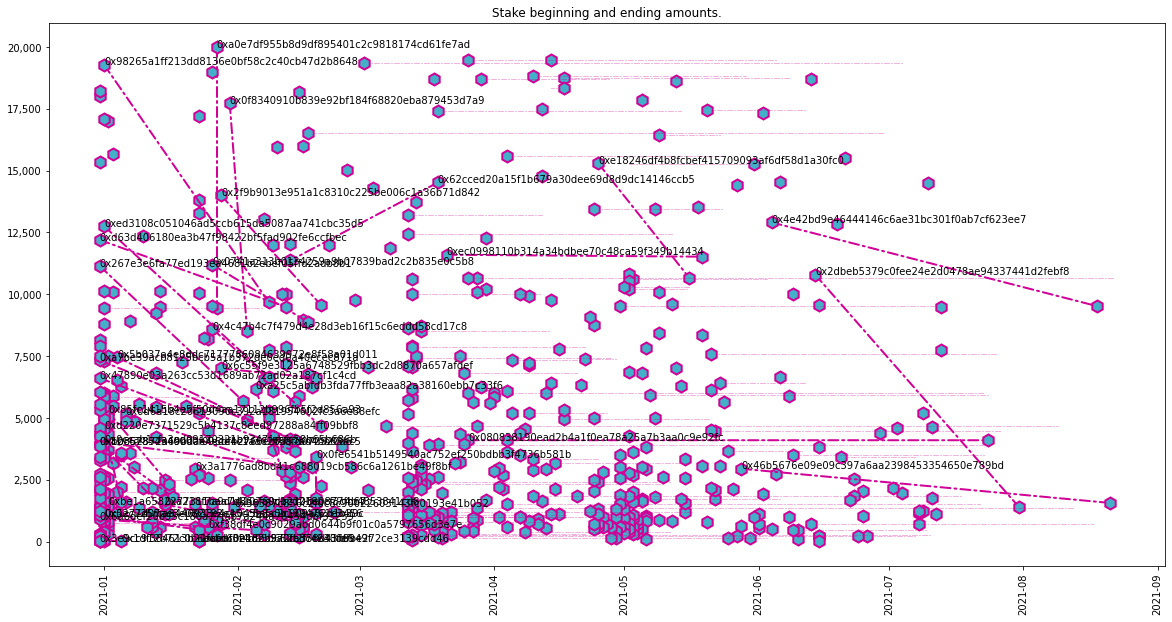

In [93]:
best = pd.read_sql("""SELECT fromaddress, to_timestamp(avg(extract(epoch from stakedatetime)))::date AS avgstakedate, to_timestamp(avg(extract(epoch from unstakedatetime)))::date AS avgunstakedate, COUNT(fromaddress) AS stakecount, SUM(amountin) as staketotal, SUM(unstakeearlyburnedamount) as burntotal
FROM stakes
WHERE stakedatetime < '2021-07-15'::date
GROUP BY fromaddress
HAVING SUM(amountin) < 20000
ORDER BY avgstakedate DESC;""",conn)
# display(best)

fig, ax1 = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
plt.xticks(rotation = 90)

x1 = best["avgstakedate"]
x2 = best["avgunstakedate"]
y1 = best["staketotal"]
y2 = best["burntotal"]
for i in range(0, len(x1)):
    if np.isnan(y2[i]):
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]], color='#D10097', linewidth=1, alpha=0.3, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
    else:
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]-y2[i]], color='#D10097', linewidth=2, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
        ax1.annotate(best["fromaddress"][i], xy=(x1[i], y1[i]))
    ax1.plot([x1[i]], [y1[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)
    ax1.plot([x2[i]], [y1[i]-y2[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Stake beginning and ending amounts.")
plt.show()

In [74]:
best = pd.read_sql("""SELECT fromaddress, to_timestamp(avg(extract(epoch from stakedatetime)))::date AS avgstakedate, to_timestamp(avg(extract(epoch from unstakedatetime)))::date AS avgunstakedate, COUNT(fromaddress) AS stakecount, SUM(amountin) as staketotal, SUM(amountin) - SUM(unstakeearlyburnedamount) as unstaketotal
FROM stakes
WHERE stakedatetime < '2021-07-15'::date
GROUP BY fromaddress
HAVING sum(amountin) - SUM(unstakeearlyburnedamount) > 13000 AND sum(amountin) - SUM(unstakeearlyburnedamount) < 15000
ORDER BY avgstakedate DESC;""",conn)
display(best)

,fromaddress,avgstakedate,avgunstakedate,stakecount,staketotal,unstaketotal
0,0xe3b4aa2dfe3a8e4cf2d901dbc7367d59bcf35eb9,2021-05-19,2021-07-30,1,"22,580.55","13,554.84"


In [15]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.read_sql("""SELECT stakedatetime AS "Stake Date", COUNT(fromaddress) AS "Number of Stakes", SUM(amountin) as "Total Staked"
FROM stakes
WHERE stakedatetime >= '2021-07-29'::date AND stakedatetime <= '2021-08-02'::date
GROUP BY stakedatetime
ORDER BY stakedatetime DESC;""",conn)

,Stake Date,Number of Stakes,Total Staked
0,2021-08-02,8,"214,767.00"
1,2021-08-01,16,"695,127.74"
2,2021-07-31,52,"990,518.25"
3,2021-07-30,22,"1,565,744.99"
4,2021-07-29,4,"153,300.17"


In [16]:
pd.read_sql("""SELECT fromaddress AS "Account", SUM(amountin) as "Total Staked"
FROM stakes
WHERE stakedatetime >= '2021-07-29'::date AND stakedatetime <= '2021-08-02'::date
GROUP BY fromaddress
ORDER BY "Total Staked" DESC
LIMIT 10;""",conn)

,Account,Total Staked
0,0x254242457f3f61d9050e451a61a107ea92d5e2b1,"706,822.60"
1,0x7407ca3def8bda3239fc7069863c54f2cc2c80bd,"649,379.25"
2,0xbe4c3b530b92157811ef87f53123753a9cf0012c,"335,905.30"
3,0x7f36ed45831bc34e38fd27145b6f983856fcb0dd,"219,520.32"
4,0xab47e1ce605580c42a1b1eca12831b17a18ea282,"173,528.30"
5,0x4bf4e3a59add035c479cde89d98103cb65dca941,"153,300.17"
6,0xe30dfd4c4d7e6b9a43c634826ebc89c137ee116b,"152,482.56"
7,0xda5b9c259ed8cd691eeac28206930fbbaf8a9574,"105,200.35"
8,0xcd0eb48851856f64b7c3e0644c08c252876e6b05,"69,009.58"
9,0xe8bf41d8506d1578c746ccd22a8f1b202c5b7e36,"67,056.87"


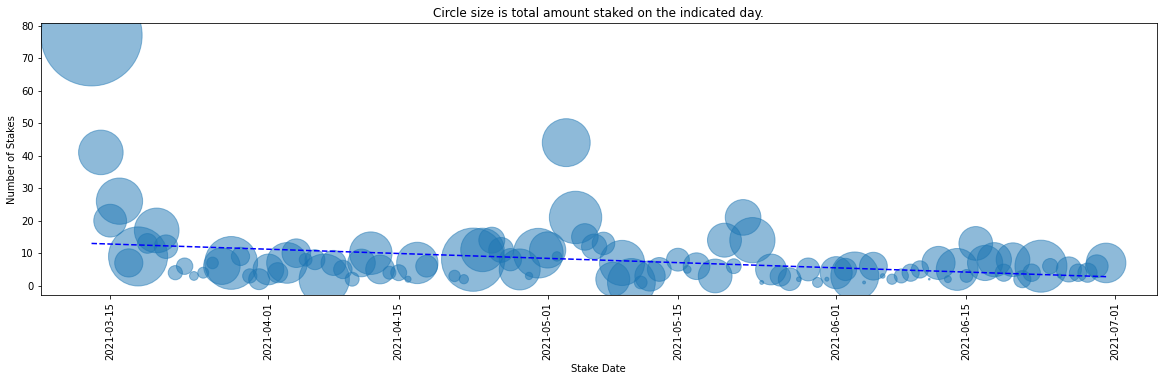

In [17]:
freq = pd.read_sql("""SELECT stakedatetime AS "Stake Date", COUNT(fromaddress) AS "Number of Stakes", SUM(amountin) as "Total Staked"
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND flashversion=2
GROUP BY stakedatetime
ORDER BY stakedatetime DESC;""",conn)

ax = freq.plot.scatter(x="Stake Date", y="Number of Stakes", s=freq["Total Staked"] / 200, rot=90, alpha=0.5, figsize=(20,5));
plt.title("Circle size is total amount staked on the indicated day.")

# Regression Fitting
x = mdates.date2num(freq["Stake Date"])
y = freq["Number of Stakes"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
plt.show()

In [19]:
# freq = pd.read_sql("""SELECT stakedatetime AS "Stake Date", COUNT(fromaddress) AS "Number of Stakes", SUM(amountin) as "Total Staked"
# FROM stakes
# WHERE stakedatetime < '2021-07-01'::date AND flashversion=2
# GROUP BY stakedatetime
# ORDER BY stakedatetime DESC;""",conn)

freq = pd.read_sql("""SELECT stakedatetime AS "Stake Date", COUNT(fromaddress) AS "Number of Stakes", SUM(amountin) as "Total Staked"
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND flashversion=2
GROUP BY stakedatetime
ORDER BY stakedatetime DESC;""",conn)

# ax = freq.plot.scatter(x="Stake Date", y="Number of Stakes", s=freq["Total Staked"] / 200, rot=90, alpha=0.5, figsize=(20,5));
# plt.title("Circle size is total amount staked on the indicated day.")

# # Regression Fitting
# x = mdates.date2num(freq["Stake Date"])
# y = freq["Number of Stakes"]
# z = np.polyfit(x, y, 1)
# p = np.poly1d(z)
# plt.plot(x,p(x),"b--")
plt.show()

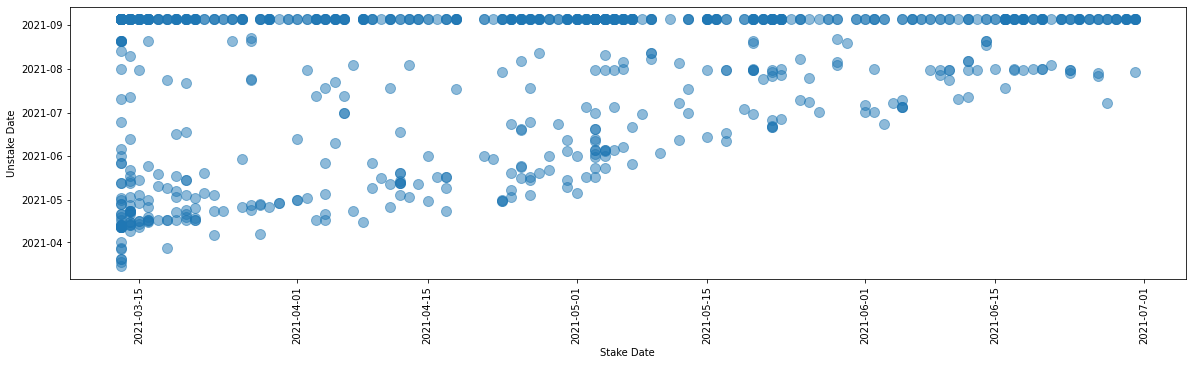

In [20]:
freq = pd.read_sql("""SELECT amountin as "Total Staked", stakedatetime AS "Stake Date", coalesce(unstakedatetime, CURRENT_DATE) AS "Unstake Date"
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND flashversion=2
ORDER BY stakedatetime DESC;""",conn)

# ax = freq.plot.scatter(x="Stake Date", y="Number of Stakes", s=freq["Total Staked"] / 200, rot=90, alpha=0.5, figsize=(20,5));
freq.plot.scatter(x="Stake Date", y="Unstake Date", s=100, rot=90, alpha=0.5, figsize=(20,5));
# freq.plot.line(x="Stake Date", y="Unstake Date");
# plt.title("Circle size is total amount staked on the indicated day.")
plt.show()

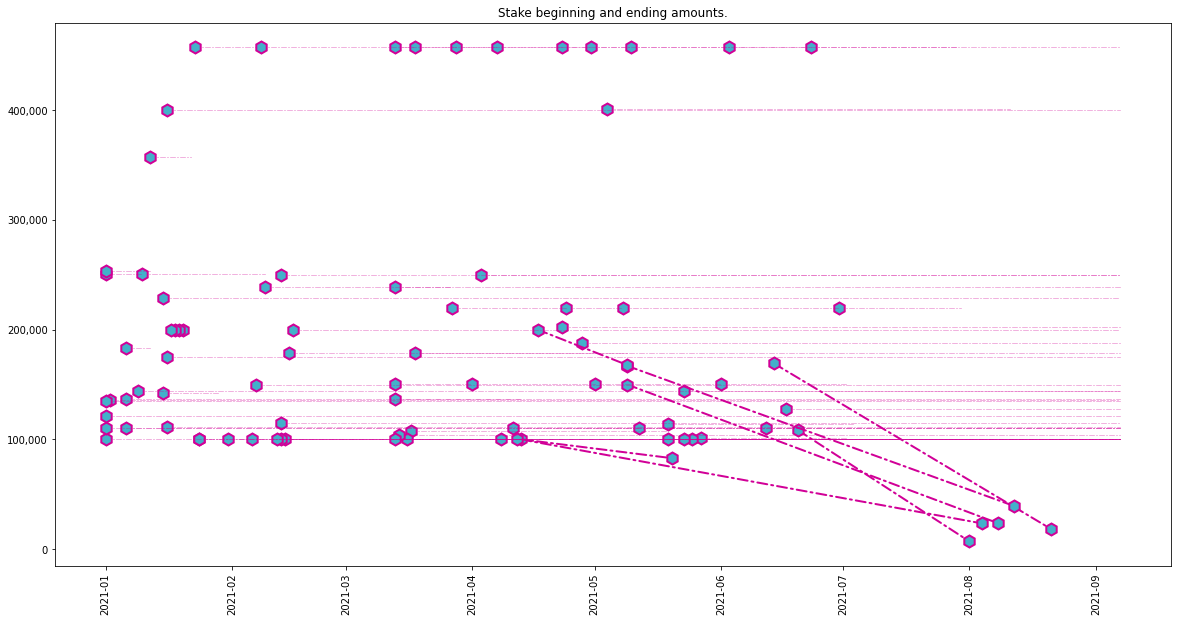

In [58]:
freq = pd.read_sql("""SELECT amountin, stakedatetime, coalesce(unstakedatetime, CURRENT_DATE) AS unstakedatetime, unstakeearlyburnedamount
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND amountin >= 100000
ORDER BY stakedatetime DESC;""",conn)

fig, ax1 = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
plt.xticks(rotation = 90)

x1 = freq["stakedatetime"]
x2 = freq["unstakedatetime"]
y1 = freq["amountin"]
y2 = freq["unstakeearlyburnedamount"]
for i in range(0, len(x1)):
    if np.isnan(y2[i]):
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]], color='#D10097', linewidth=1, alpha=0.3, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
    else:
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]-y2[i]], color='#D10097', linewidth=2, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
    ax1.plot([x1[i]], [y1[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)
    ax1.plot([x2[i]], [y1[i]-y2[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Stake beginning and ending amounts.")
plt.show()

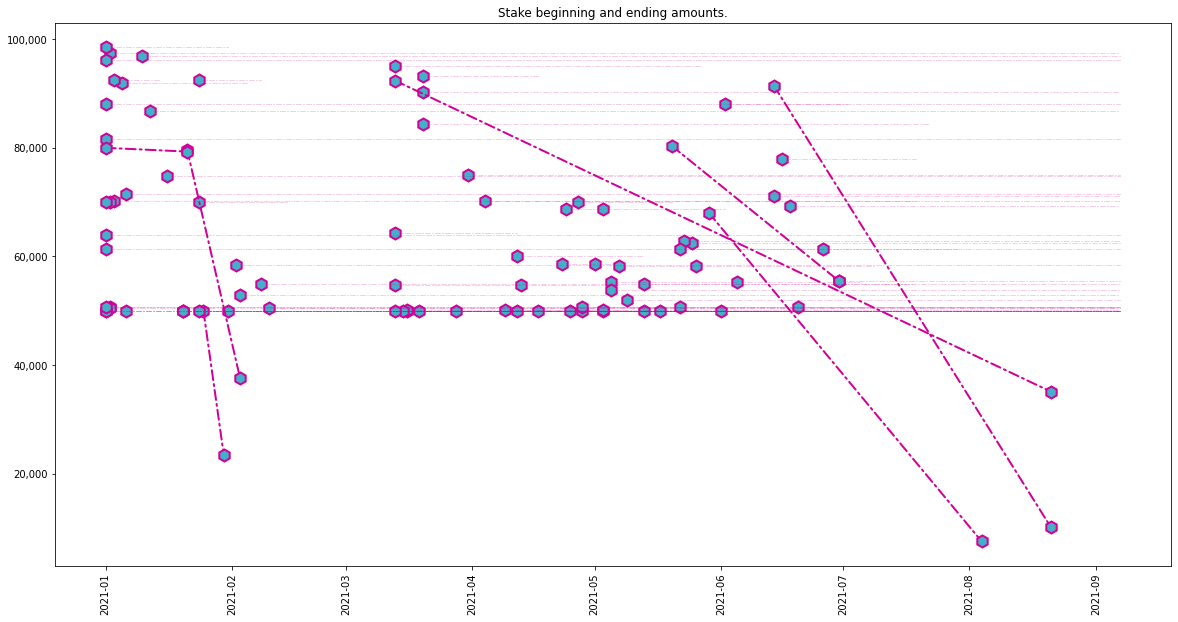

In [59]:
freq = pd.read_sql("""SELECT amountin, stakedatetime, coalesce(unstakedatetime, CURRENT_DATE) AS unstakedatetime, unstakeearlyburnedamount
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND (amountin >= 50000 AND amountin < 100000)
ORDER BY stakedatetime DESC;""",conn)
# AND flashversion=2

fig, ax1 = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
plt.xticks(rotation = 90)

x1 = freq["stakedatetime"]
x2 = freq["unstakedatetime"]
y1 = freq["amountin"]
y2 = freq["unstakeearlyburnedamount"]
for i in range(0, len(x1)):
    if np.isnan(y2[i]):
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]], color='#D10097', linewidth=1, alpha=0.2, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
    else:
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]-y2[i]], color='#D10097', linewidth=2, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
    ax1.plot([x1[i]], [y1[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)
    ax1.plot([x2[i]], [y1[i]-y2[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Stake beginning and ending amounts.")
plt.show()

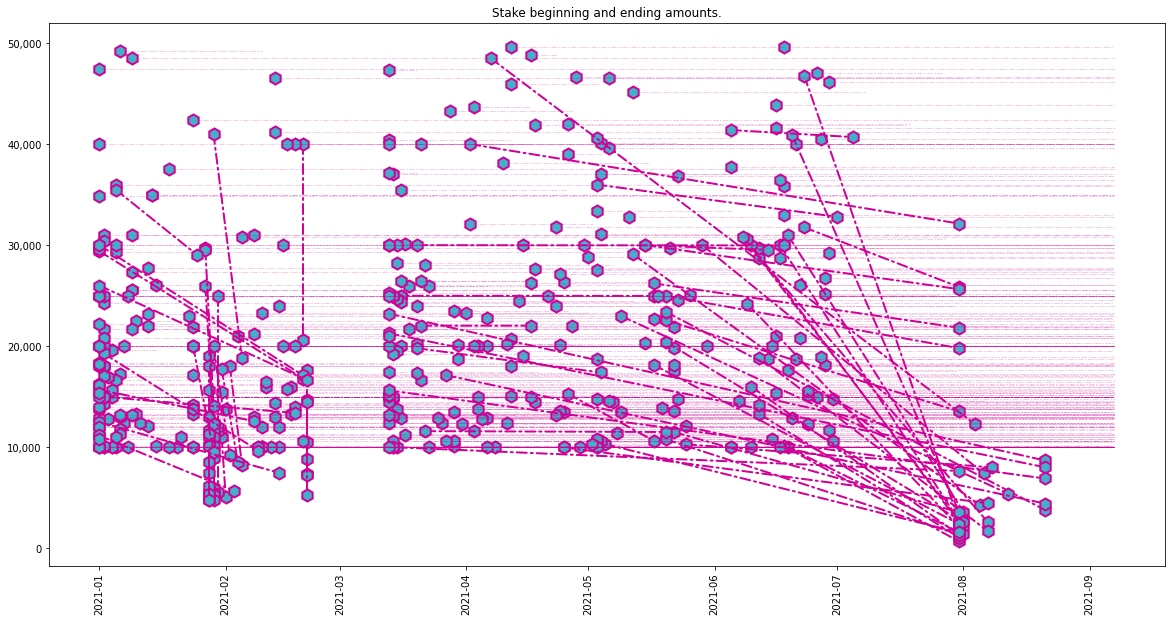

In [67]:
freq = pd.read_sql("""SELECT amountin, stakedatetime, coalesce(unstakedatetime, CURRENT_DATE) AS unstakedatetime, unstakeearlyburnedamount
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND (amountin >= 10000 AND amountin < 50000)
ORDER BY stakedatetime DESC;""",conn)
# AND flashversion=2

fig, ax1 = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
plt.xticks(rotation = 90)

x1 = freq["stakedatetime"]
x2 = freq["unstakedatetime"]
y1 = freq["amountin"]
y2 = freq["unstakeearlyburnedamount"]
for i in range(0, len(x1)):
    if np.isnan(y2[i]):
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]], color='#D10097', linewidth=1, alpha=0.2, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
    else:
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]-y2[i]], color='#D10097', linewidth=2, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
    ax1.plot([x1[i]], [y1[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)
    ax1.plot([x2[i]], [y1[i]-y2[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Stake beginning and ending amounts.")
plt.show()

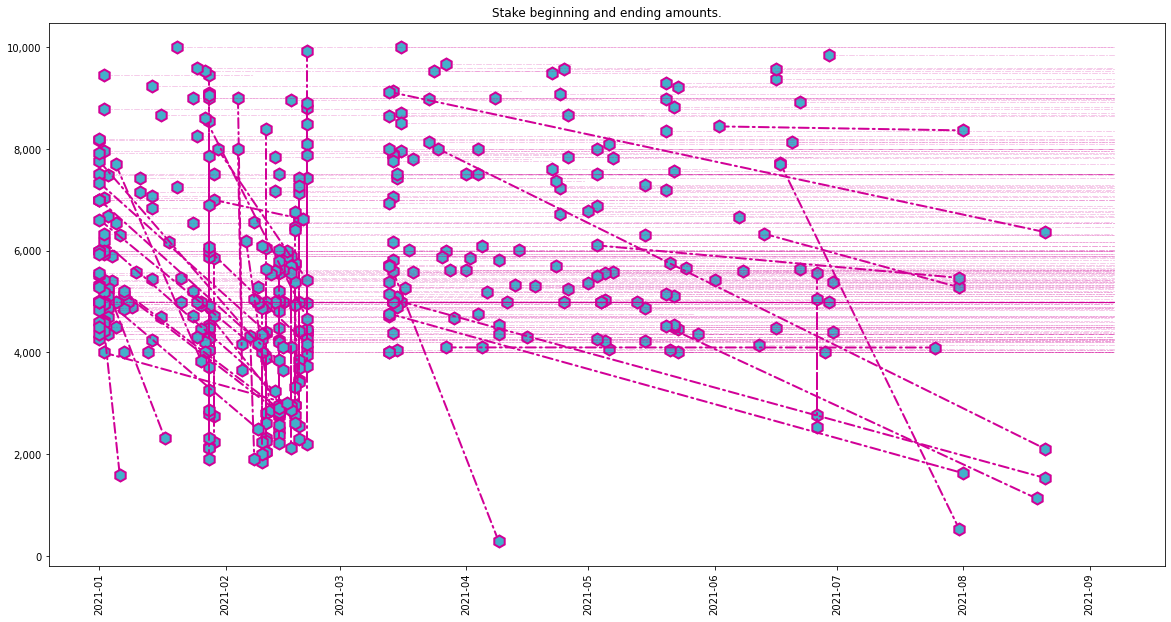

In [68]:
freq = pd.read_sql("""SELECT amountin, stakedatetime, coalesce(unstakedatetime, CURRENT_DATE) AS unstakedatetime, unstakeearlyburnedamount
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND (amountin >= 4000 AND amountin < 10000)
ORDER BY stakedatetime DESC;""",conn)
# AND flashversion=2

fig, ax1 = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
plt.xticks(rotation = 90)

x1 = freq["stakedatetime"]
x2 = freq["unstakedatetime"]
y1 = freq["amountin"]
y2 = freq["unstakeearlyburnedamount"]
for i in range(0, len(x1)):
    if np.isnan(y2[i]):
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]], color='#D10097', linewidth=1, alpha=0.2, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
    else:
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]-y2[i]], color='#D10097', linewidth=2, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
    ax1.plot([x1[i]], [y1[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)
    ax1.plot([x2[i]], [y1[i]-y2[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.title("Stake beginning and ending amounts.")
plt.show()

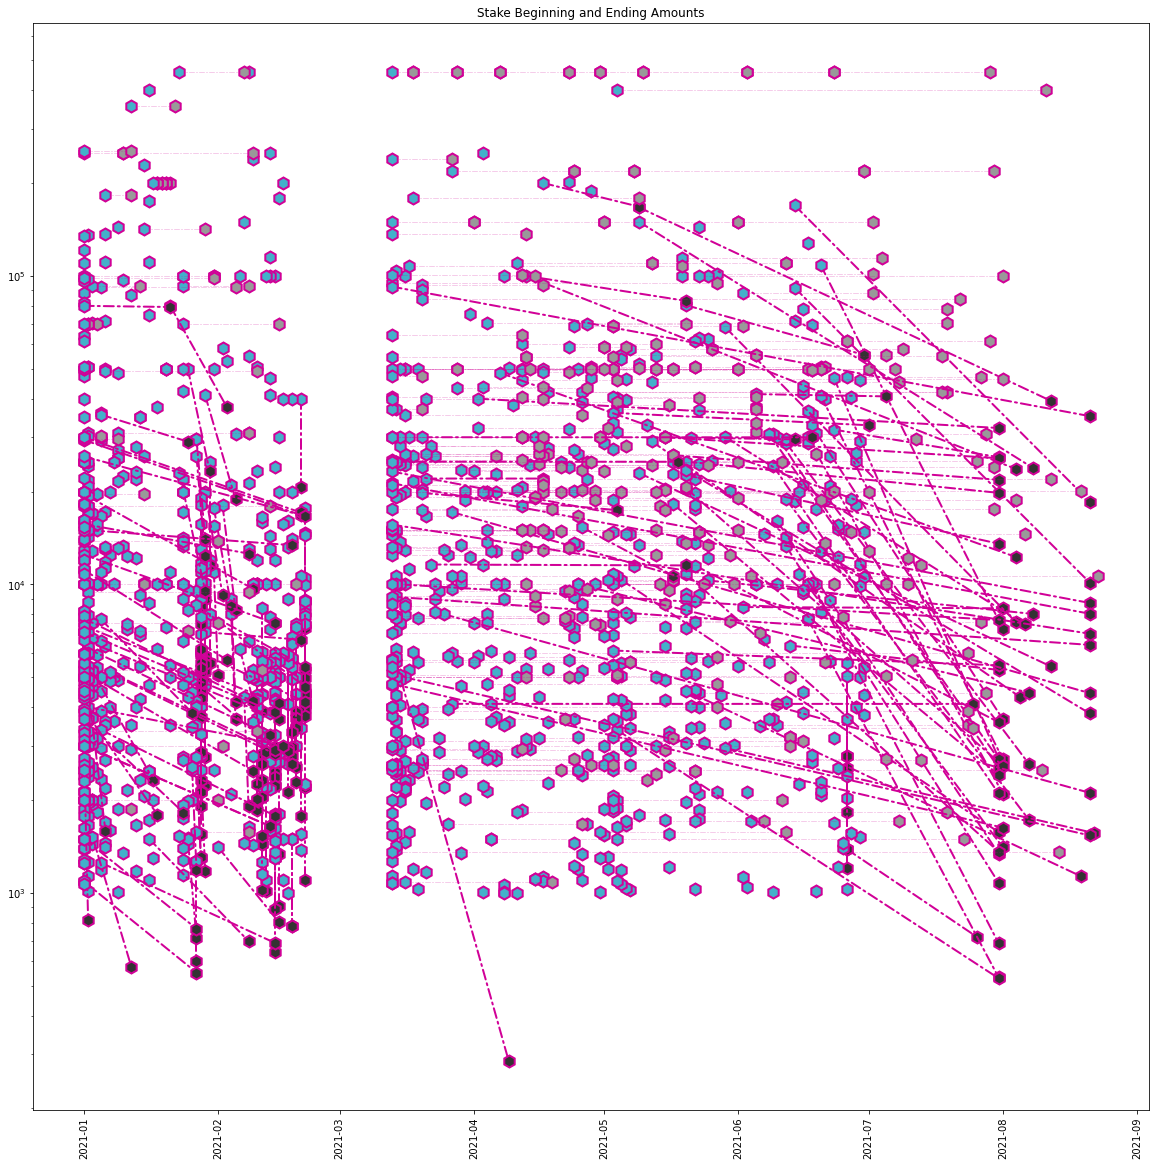

In [241]:
# coalesce(unstakedatetime, CURRENT_DATE) AS 
freq = pd.read_sql("""SELECT amountin, stakedatetime, unstakedatetime, unstakeearlyburnedamount
FROM stakes
WHERE stakedatetime < '2021-07-01'::date AND (amountin > 1000 AND amountin < 1000000)
ORDER BY stakedatetime DESC;""",conn)
# AND flashversion=2

fig, ax1 = plt.subplots(figsize=(20, 20))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
plt.xticks(rotation = 90)

x1 = freq["stakedatetime"]
x2 = freq["unstakedatetime"]
y1 = freq["amountin"]
y2 = freq["unstakeearlyburnedamount"]
for i in range(0, len(x1)):
    if np.isnan(y2[i]):
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]], color='#D10097', linewidth=1, alpha=0.2, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
        ax1.plot([x2[i]], [y1[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#999', markeredgewidth=2, markersize=12, markevery=3)
#         if x2[i] is None:
#             ax1.plot([x1[i],datetime.date.today()], [y1[i],y1[i]], color='#D10097', linewidth=1, alpha=0.2, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
    else:
        ax1.plot([x1[i],x2[i]], [y1[i],y1[i]-y2[i]], color='#D10097', linewidth=2, linestyle=(0, (5, 2, 1, 2)), dash_capstyle='round')
        ax1.plot([x2[i]], [y1[i]-y2[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#333', markeredgewidth=2, markersize=12, markevery=3)
    ax1.plot([x1[i]], [y1[i]], color='#D10097', linewidth=4, marker='h', markerfacecolor='#43B0CA', markeredgewidth=2, markersize=12, markevery=3)

ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.set_yscale('log')
plt.title("Stake Beginning and Ending Amounts")
plt.show()

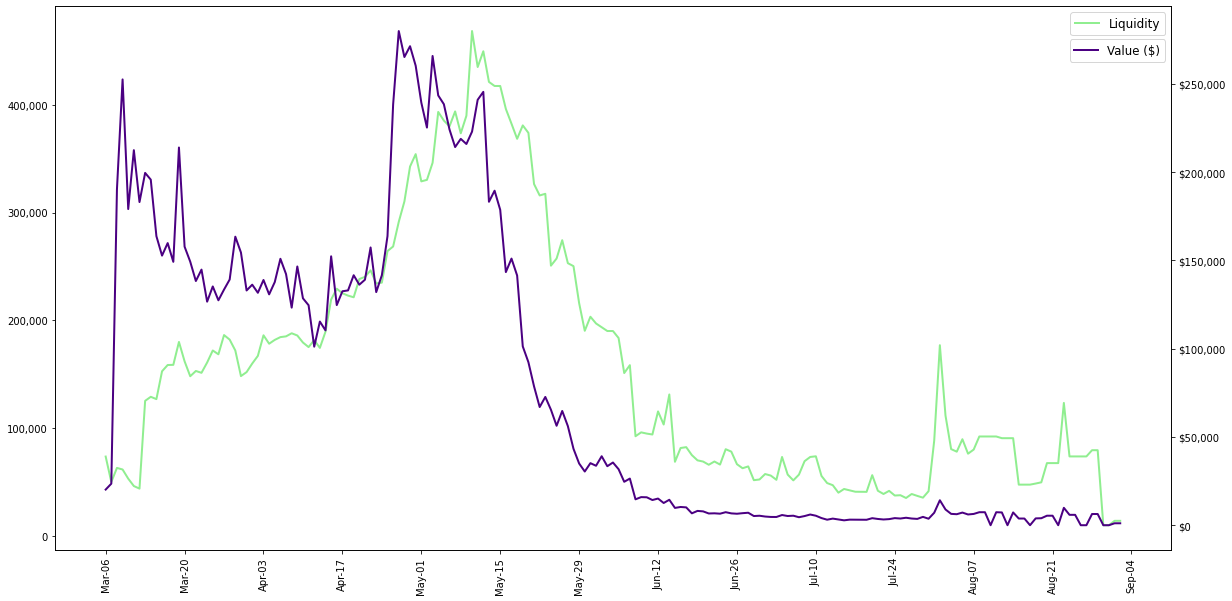

In [22]:
px = pd.read_sql("""SELECT *
FROM uniswap;""",conn)

fig, ax1 = plt.subplots(figsize=(20, 10))
plt.xticks(rotation = 90)
ax1.plot(px["date"], px["liquidity"], color='lightgreen', linewidth=2, label="Liquidity")
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
# ax1.legend("Liquidity", bbox_to_anchor = (1.05, 0.6))
ax1.legend(bbox_to_anchor = (1, 1), prop={'size':12})
ax2 = ax1.twinx()
ax2.plot(px["date"], px["value"], color='#4b0082', linewidth=2, label="Value ($)")
# ax2.set_ylim([0, 5])
ax2.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=14))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax2.legend(bbox_to_anchor = (1, .95), prop={'size':11.75})
plt.show()

In [44]:
# freq = pd.read_sql("""SELECT stakedatetime AS "Stake Date", COUNT(fromaddress) AS "Number of Stakes", SUM(amountin) as "Total Staked"
# FROM stakes
# WHERE stakedatetime < '2021-07-01'::date AND flashversion=2
# GROUP BY stakedatetime
# ORDER BY stakedatetime DESC;""",conn)

hist = pd.read_sql("""SELECT *
FROM uniswap uni
LEFT JOIN
    (
        SELECT stakedatetime, COUNT(fromaddress) AS stakecount, SUM(amountin) staketotal
        FROM stakes
        GROUP BY stakedatetime
    ) AS s1
ON s1.stakedatetime=uni.date
LEFT JOIN
    (
        SELECT date AS ethdate, close AS ethclose
        FROM ethpx
    ) AS e1
ON e1.ethdate=uni.date
ORDER BY uni.date;""",conn)
# display(hist)

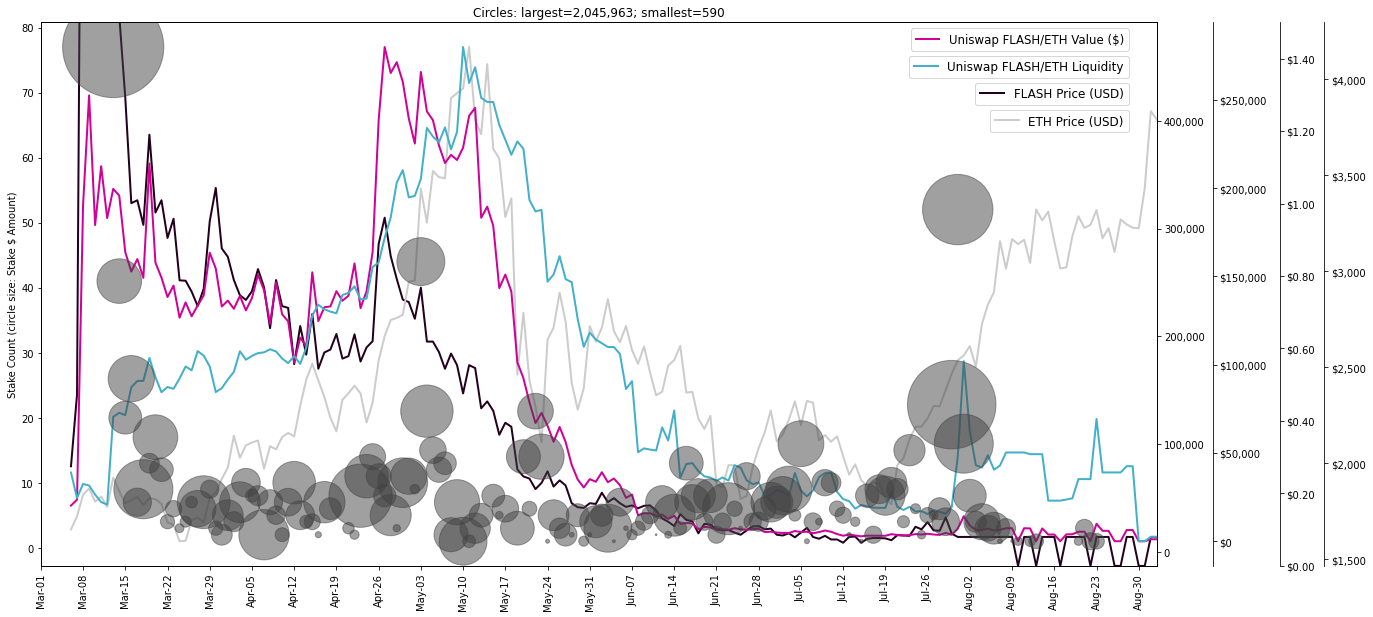

In [199]:
fig, ax1 = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1)
plt.xticks(rotation = 90)

# Plot the stake data
# ax1.scatter(hist["date"], hist["stakecount"], s=hist["staketotal"] / 200, color='#cad084', alpha=0.7)
sc = ax1.scatter(hist["date"], hist["stakecount"], s=hist["staketotal"] / 200, color='#424242', alpha=0.5, zorder=50, label="Total Stake Amount")
ax1.zorder = 5
ax1.patch.set_alpha(0)
ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax1.set_ylabel('Stake Count (circle size: Stake $ Amount)')
ax1.set_xlim([datetime.date(2021,3,1), datetime.date(2021,9,2)])
# ax1.legend(*sc.legend_elements("sizes", num=2), loc="upper right", title="Size")
# print(sc.legend_elements())
totalsfiltered = list(filter(lambda x: pd.isnull(x) != True, hist["staketotal"]))
# plt.title("Circles: largest=%.2f, smallest=%.2f" % (max(totalsfiltered), min(totalsfiltered)))
plt.title("Circles: largest={:,.0f}; smallest={:,.0f}".format(max(totalsfiltered), min(totalsfiltered)))
# handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
# legend2 = ax1.legend(handles, labels, loc="upper right", title="Sizes")

# Plot the stake data Regression Fit line
x = mdates.date2num(hist["date"])
y = hist["stakecount"]
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax2 = ax1.twinx()
# plt.plot(x, p(x), "--", color='#3C3E27', alpha=0.8)
ax2.plot(x, p(x), "--", color='#424242', alpha=0.99)
ax2.zorder = 6
ax2.patch.set_alpha(0)
ax2.set_ylim([0, 80])
ax2.yaxis.set_visible(False)

# Plot the Uniswap FLASH/ETH pool historical liquidity value
ax3 = ax1.twinx()
ax3.plot(hist["date"], hist["value"], color='#D10097', linewidth=2, label="Uniswap FLASH/ETH Value ($)", zorder=10)
ax3.zorder = 2
ax3.patch.set_alpha(0)
ax3.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax3.legend(bbox_to_anchor = (.98, 1), prop={'size':11.75})

ax3.spines['right'].set_position(("axes", 1.05))
ax3.spines['right'].set_visible(True)
ax3.yaxis.set_label_position('right')
ax3.yaxis.set_ticks_position('right')

# Plot the Uniswap FLASH/ETH pool historical liquidity quantity
ax4 = ax1.twinx()
ax4.plot(hist["date"], hist["liquidity"], color='#43B0CA', linewidth=2, label="Uniswap FLASH/ETH Liquidity", zorder=5)
ax4.zorder = 3
ax4.patch.set_alpha(0)
ax4.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax4.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
# ax4.legend("Liquidity", bbox_to_anchor = (1.05, 0.6))
ax4.legend(bbox_to_anchor = (.98, .95), prop={'size':12})

# Plot the Uniswap FLASH/USD price
ax5 = ax1.twinx()
ax5.plot(hist["date"], hist["price"], color='#23001E', linewidth=2, label="FLASH Price (USD)", zorder=0)
ax5.zorder = 1
ax5.patch.set_alpha(0)
ax5.set_ylim([0, 1.5])
ax5.yaxis.set_major_formatter(StrMethodFormatter('${x:,.2f}'))
ax5.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax5.legend(bbox_to_anchor = (.98, .9), prop={'size':12})

ax5.spines['right'].set_position(("axes", 1.11))
ax5.spines['right'].set_visible(True)
ax5.yaxis.set_label_position('right')
ax5.yaxis.set_ticks_position('right')

# Plot the ETH/USD price
ax6 = ax1.twinx()
ax6.plot(hist["date"], hist["ethclose"], color='#CCC', linewidth=2, label="ETH Price (USD)", zorder=0)
ax6.zorder = 1
ax6.patch.set_alpha(0)
# ax6.set_ylim([0, 1.5])
ax6.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax6.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
ax6.legend(bbox_to_anchor = (.98, .85), prop={'size':12})

ax6.spines['right'].set_position(("axes", 1.15))
ax6.spines['right'].set_visible(True)
ax6.yaxis.set_label_position('right')
ax6.yaxis.set_ticks_position('right')

plt.show()

In [164]:
# pd.set_option('display.max_rows', 100)
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.read_sql("""SELECT *
FROM uniswap uni
LEFT JOIN
    (
        SELECT stakedatetime, COUNT(fromaddress) AS stakecount, SUM(amountin) staketotal
        FROM stakes
        GROUP BY stakedatetime
        ORDER BY stakedatetime DESC
    ) AS s1
ON s1.stakedatetime=uni.date
ORDER BY uni.date
LIMIT 10;""",conn)

,date,liquidity,value,price,stakedatetime,stakecount,staketotal
0,2021-03-13,"125,151.16","199,616.10",1.59,2021-03-13,77,"2,045,963.23"


In [179]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.read_sql("""SELECT fromaddress, stakedatetime, amountin, mintedamount, expiredatetime, totalstakeddays, dapprewardamount, unstakedatetime, unstakeearlyburnedamount, matchedamount, flashversion
FROM stakes
WHERE stakedatetime='2021-03-13'::date
ORDER BY amountin DESC
LIMIT 10;""",conn)

,fromaddress,stakedatetime,amountin,mintedamount,expiredatetime,totalstakeddays,dapprewardamount,unstakedatetime,unstakeearlyburnedamount,matchedamount,flashversion
0,0x7dc0a282fcc494ef0ea59cba06f8709c04c1aee5,2021-03-13,"456,971.00","2,421.54",2021-03-18,5.00,1.45,2021-03-18,NaN,363.23,2
1,0x7f36ed45831bc34e38fd27145b6f983856fcb0dd,2021-03-13,"239,000.00","4,346.45",2021-03-27,14.00,2.72,2021-03-27,NaN,651.97,2
2,0xff6992fda98a9452e2eb0487e17533f428be6bdc,2021-03-13,"150,100.00","2,575.30",2021-03-30,17.00,1.91,2021-04-01,NaN,386.30,2
3,0xd0f50c0431b76fa58aeefdd68617acb4e0628051,2021-03-13,"136,422.00","4,967.91",2021-04-12,30.00,2.91,2021-04-13,NaN,745.19,2
4,0xb33465e0f999e1199c7ecc0196724df89665888d,2021-03-13,"100,581.00","3,832.27",2021-04-12,30.00,2.08,2021-04-12,NaN,574.84,2
5,0xe30dfd4c4d7e6b9a43c634826ebc89c137ee116b,2021-03-13,"95,027.76","7,209.58",2021-05-24,72.00,4.50,2021-05-27,NaN,"1,081.44",2
6,0xc848b603a557bef9dc9c3e8d9737691586b9e56b,2021-03-13,"92,385.90","45,859.06",2022-05-11,424.00,21.92,2021-08-21,"57,264.77","6,878.86",2
7,0xaaf1eb836c73fe48fe67150bd5eb412deb39de23,2021-03-13,"64,258.54","2,400.78",2021-04-12,30.00,1.45,2021-04-12,NaN,360.12,2
8,0xe4344b1ce3d141f113d7f04e8df4f2946dfce4af,2021-03-13,"54,776.08","1,654.32",2021-04-12,30.00,1.21,2021-04-13,NaN,248.15,2
9,0x8c7f8e274c0a22368eab10fed7608f7e7e5546ee,2021-03-13,"50,000.00",784.87,2021-03-28,15.00,0.57,2021-03-28,NaN,117.73,2


In [22]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.read_sql("""SELECT fromaddress, SUM(value) AS "deposited"
FROM uniswaptx
WHERE datetime='2021-03-13'::date AND (direction='IN' AND tokensymbol='FLASH')
GROUP BY fromaddress
ORDER BY deposited DESC
LIMIT 10;""",conn)

,fromaddress,deposited
0,0xc6e6dd6a0c61651d1bc055dc1c22418a729d41bb,108950.719313
1,0x51acf0af77adcb20de482e1cd678f620baf07e0c,75661.747696
2,0x7b78eb388fe213037b0f558a4a5935fe27b1e481,60390.659153
3,0x7a08ed5862ba4c2887ef169a17637eadb27beecf,49868.580553
4,0x0000000008c9f3e47c663451c87dc7ae4d029c9b,41873.465791
5,0xb267a6cc3c4ef82326b802cfa7093c4be4c25c11,41605.000000
6,0x00000000acd5ca17eee6d92d9ca121543126cce1,37970.832088
7,0xa077f451c39dfe17bf5bead6be51ec99124534fd,35695.635643
8,0x423f7e311867ffa7faa03a1d8f8801642f11a57d,35104.536450
9,0x6e3b517074da068d52cff10d914b502d762e5c52,34292.661802


In [26]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.read_sql("""SELECT stakes.fromaddress, stakedatetime, u2."Liquidity (WETH) Deposited", amountin, mintedamount, expiredatetime, totalstakeddays, dapprewardamount, unstakedatetime, unstakeearlyburnedamount, matchedamount, flashversion
FROM stakes
INNER JOIN
    (
        SELECT fromaddress, SUM(value) AS "Liquidity (WETH) Deposited"
        FROM uniswaptx
        WHERE datetime='2021-03-13'::date AND (direction='IN' AND tokensymbol='WETH') 
        GROUP BY fromaddress
    ) AS u2
ON u2.fromaddress=stakes.fromaddress
WHERE stakedatetime='2021-03-13'::date
ORDER BY amountin DESC;""",conn)

,fromaddress,stakedatetime,Liquidity (WETH) Deposited,amountin,mintedamount,expiredatetime,totalstakeddays,dapprewardamount,unstakedatetime,unstakeearlyburnedamount,matchedamount,flashversion
0,0xaaf1eb836c73fe48fe67150bd5eb412deb39de23,2021-03-13,1.452202,64258.543502,2400.784578,2021-04-12,30.0,1.452202,2021-04-12,None,360.117687,2
1,0x109cbb5f91951b29c025294ea2b8678ff1386d0e,2021-03-13,0.261600,5695.994770,678.057324,2021-07-09,118.0,0.495961,2021-07-11,None,101.708599,2
2,0x588031347beaa0d43978bc8c0094138a67d1a071,2021-03-13,0.262229,2503.702583,92.204194,2021-04-17,35.0,0.061915,2021-04-21,None,13.830629,2
3,0x588031347beaa0d43978bc8c0094138a67d1a071,2021-03-13,0.262229,631.165055,22.178752,2021-04-17,35.0,75.876116,2021-04-21,None,3.326813,2


In [39]:
pd.read_sql("""SELECT tokensymbol, TO_CHAR(SUM(value), '999,999,999.99') AS "deposited amount"
FROM uniswaptx
WHERE datetime='2021-03-13'::date AND direction='IN' 
GROUP BY tokensymbol;""",conn)

,tokensymbol,deposited amount
0,WETH,713.65
1,UNI-V2,265.90
2,FLASH,"1,105,922.96"


In [41]:
pd.read_sql("""SELECT *
FROM ethpx
LIMIT 10;""",conn)

,date,open,high,low,close,volume,marketcap
0,2021-09-07,3926.53,3945.31,3062.22,3426.39,3.913135e+10,4.023659e+11
1,2021-09-06,3951.52,3968.43,3868.99,3928.38,1.867469e+10,4.612614e+11
2,2021-09-05,3886.33,3979.19,3838.49,3952.13,1.837147e+10,4.639973e+11
3,2021-09-04,3937.91,3969.45,3837.93,3887.83,2.080696e+10,4.563950e+11
4,2021-09-03,3787.49,4022.47,3712.68,3940.61,2.620777e+10,4.625385e+11
5,2021-09-02,3825.03,3830.71,3726.75,3790.99,2.438740e+10,4.449249e+11
6,2021-09-01,3430.76,3836.87,3387.41,3834.83,3.007089e+10,4.500175e+11
7,2021-08-31,3227.76,3466.99,3195.22,3433.73,2.728050e+10,4.029028e+11
8,2021-08-30,3227.19,3346.58,3151.44,3224.37,1.930692e+10,3.782938e+11
9,2021-08-29,3246.77,3283.24,3158.84,3227.00,1.329659e+10,3.785586e+11
